## Install dependencies

In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt

Import all the requires liberies

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

# traning and test data path loading

In [4]:
train_path, test_path = "./Train", "./Test/"
data_dir_train, data_dir_test = pathlib.Path(train_path), pathlib.Path(test_path)

Define the batchsize to 32 
and image height and width to 60 as low resulation images is bit easy to run through the model

In [5]:
batch_size = 32
img_height = 60
img_width = 60

load the traing dataset

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Get the classname for the traing dataset

In [7]:
class_names = train_ds.class_names
class_names


['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

Visualize the dataset's few images

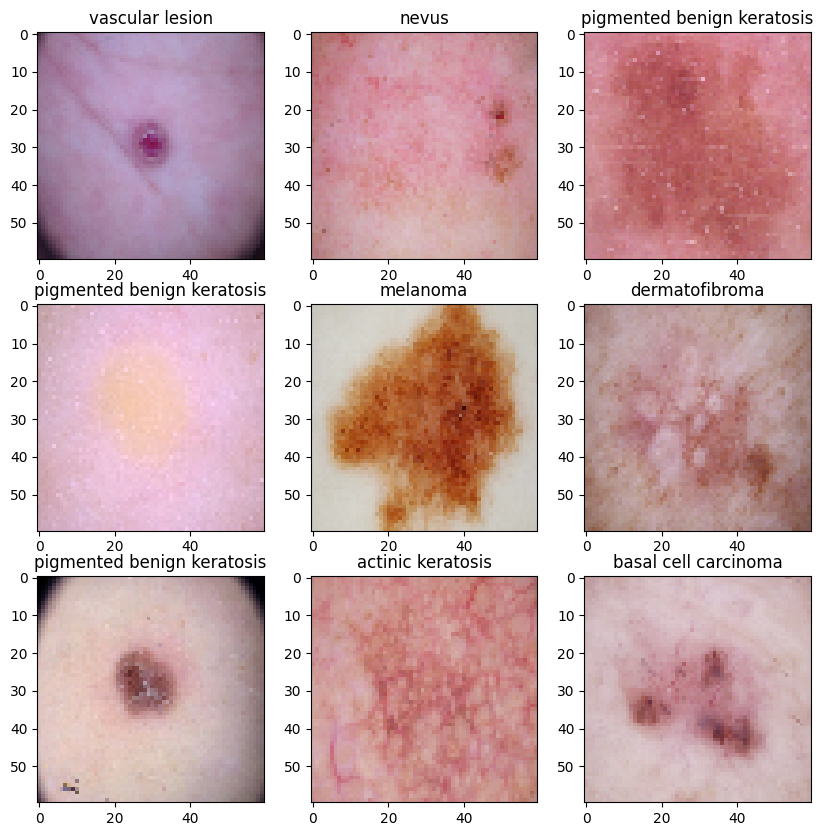

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    lable_index = np.argmax(labels[i].numpy().astype("int"))
    plt.title(class_names[lable_index])
    # plt.axis("off")

Create the validation dataset from rest 20% of the data

In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


Need to suffle the dataset for better traning of the model

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
input_shape = (img_height, img_width, 3)

In [12]:
for i in class_names:
    directory =train_path+'/'+i+'/'
    class_directory = pathlib.Path(directory)
    sample_count=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {sample_count} images.')

actinic keratosis has 114 images.
basal cell carcinoma has 376 images.
dermatofibroma has 95 images.
melanoma has 438 images.
nevus has 357 images.
pigmented benign keratosis has 462 images.
seborrheic keratosis has 77 images.
squamous cell carcinoma has 181 images.
vascular lesion has 139 images.


In the previous execution we can see there is a big class imbalance which could lead bad model.

Doing data augumentaion for the images to get a good amount of data to traing

In [13]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])

Create the first model

In [14]:
model_1=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),
    
    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),   
    Dense(9, activation='softmax')
])

In [15]:
model_1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

In [16]:
epochs = 30
history = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 18s 226ms/step - loss: 2.0664 - accuracy: 0.1975 - val_loss: 2.1064 - val_accuracy: 0.2058
Epoch 2/30
56/56 [==============================] - 12s 211ms/step - loss: 2.0387 - accuracy: 0.1953 - val_loss: 2.0168 - val_accuracy: 0.2103
Epoch 3/30
56/56 [==============================] - 11s 188ms/step - loss: 2.0225 - accuracy: 0.2160 - val_loss: 1.9405 - val_accuracy: 0.2662
Epoch 4/30
56/56 [==============================] - 11s 189ms/step - loss: 1.9351 - accuracy: 0.2617 - val_loss: 1.9679 - val_accuracy: 0.2595
Epoch 5/30
56/56 [==============================] - 11s 199ms/step - loss: 1.8927 - accuracy: 0.2723 - val_loss: 1.7976 - val_accuracy: 0.3199
Epoch 6/30
56/56 [==============================] - 11s 189ms/step - loss: 1.8833 - accuracy: 0.2829 - val_loss: 1.8880 - val_accuracy: 0.2998
Epoch 7/30
56/56 [==============================] - 11s 190ms/step - loss: 1.8291 - accuracy: 0.2941 - val_loss: 1.7918 - val_accuracy: 0.3199

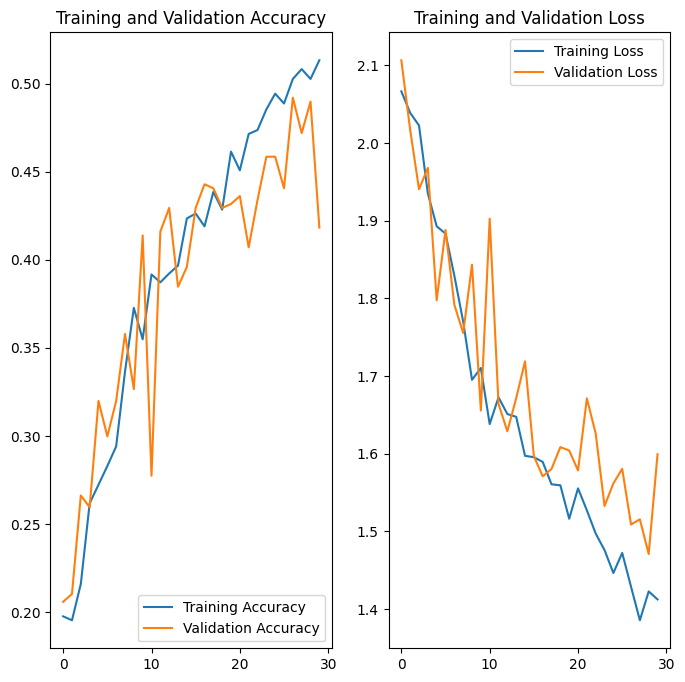

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observation :
 1. The accuracy of the model for the Training data set is at nearly 50% and the Validation accuracy is less than 45% which is not a good estimation.
 2. this could indicate that this model could be overfitted.
 3. hopefully some more layers and class reblance could be improve this result

So as earlier we have seen that there is class imbalance so to tackel that we will use Augmentor

In [18]:
import Augmentor

Here we will add 1000 more sample to per class to fix class imbalance.

In [19]:
for i in class_names:
    p = Augmentor.Pipeline(train_path+ '/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000)

Initialised with 114 image(s) found.
Output directory set to ./Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C3806F8FA0>: 100%|██████████| 1000/1000 [00:05<00:00, 172.87 Samples/s]                 


Initialised with 376 image(s) found.
Output directory set to ./Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C3185F7E50>: 100%|██████████| 1000/1000 [00:05<00:00, 176.33 Samples/s]                 


Initialised with 95 image(s) found.
Output directory set to ./Train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C3186B6160>: 100%|██████████| 1000/1000 [00:05<00:00, 191.06 Samples/s]


Initialised with 438 image(s) found.
Output directory set to ./Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1C320F8BC70>: 100%|██████████| 1000/1000 [00:29<00:00, 33.72 Samples/s]                  


Initialised with 357 image(s) found.
Output directory set to ./Train/nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C38070DA60>: 100%|██████████| 1000/1000 [00:24<00:00, 40.53 Samples/s] 


Initialised with 462 image(s) found.
Output directory set to ./Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1C31E14B610>: 100%|██████████| 1000/1000 [00:05<00:00, 186.38 Samples/s]                 


Initialised with 77 image(s) found.
Output directory set to ./Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1C38070AA00>: 100%|██████████| 1000/1000 [00:12<00:00, 79.01 Samples/s]


Initialised with 181 image(s) found.
Output directory set to ./Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C320F81A90>: 100%|██████████| 1000/1000 [00:05<00:00, 188.42 Samples/s]


Initialised with 139 image(s) found.
Output directory set to ./Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1C31B0212E0>: 100%|██████████| 1000/1000 [00:05<00:00, 188.50 Samples/s]


Checking if class imbalnce is optimized or not

In [20]:
for i in class_names:
    directory =train_path+'/'+i+'/'
    directory_out =train_path+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob('*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} images')


actinic keratosis has 1114 images
basal cell carcinoma has 1376 images
dermatofibroma has 1095 images
melanoma has 1438 images
nevus has 1357 images
pigmented benign keratosis has 1462 images
seborrheic keratosis has 1077 images
squamous cell carcinoma has 1181 images
vascular lesion has 1139 images


create the datasets from new images

In [21]:
data_dir_train=train_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


Added more layer and also set the dropout to 0.5 to achive better performance in accurecy

In [23]:
model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),         
    
    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    
    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128, kernel_size=(3, 3), activation='relu', padding = 'Same'),
    MaxPooling2D(pool_size=(2,2)),

    Dropout(0.5),   
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),   
    Dense(9, activation='softmax')
])

In [24]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')

In [25]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 77s 271ms/step - loss: 2.1532 - accuracy: 0.1392 - val_loss: 2.0206 - val_accuracy: 0.2172
Epoch 2/30
281/281 [==============================] - 72s 255ms/step - loss: 1.7496 - accuracy: 0.3072 - val_loss: 1.5481 - val_accuracy: 0.3787
Epoch 3/30
281/281 [==============================] - 72s 254ms/step - loss: 1.5280 - accuracy: 0.3996 - val_loss: 1.3387 - val_accuracy: 0.4633
Epoch 4/30
281/281 [==============================] - 72s 254ms/step - loss: 1.3722 - accuracy: 0.4646 - val_loss: 1.2685 - val_accuracy: 0.5105
Epoch 5/30
281/281 [==============================] - 70s 250ms/step - loss: 1.2749 - accuracy: 0.5028 - val_loss: 1.1545 - val_accuracy: 0.5594
Epoch 6/30
281/281 [==============================] - 69s 245ms/step - loss: 1.1803 - accuracy: 0.5455 - val_loss: 1.0582 - val_accuracy: 0.5879
Epoch 7/30
281/281 [==============================] - 69s 246ms/step - loss: 1.0561 - accuracy: 0.5938 - val_loss: 1.2077 - val_ac

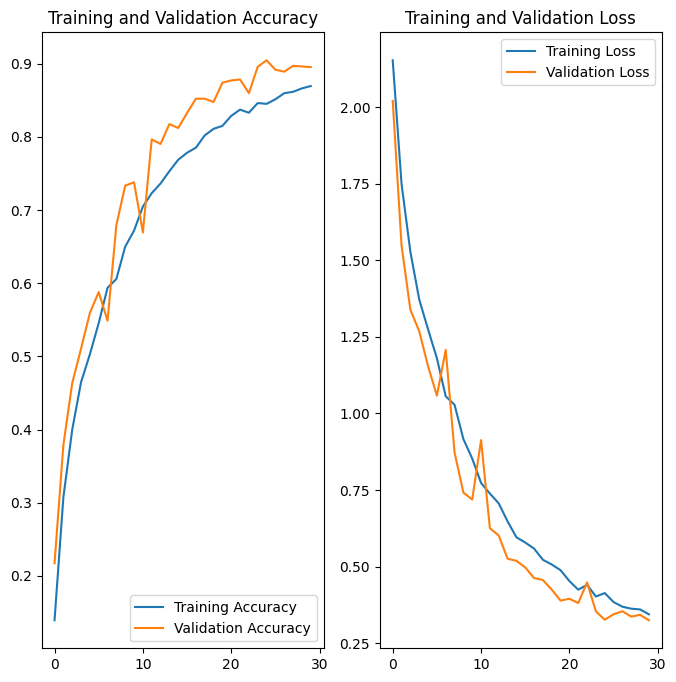

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1. The training accuracy seems to be nearly ~90%.
2. The validation accuracy is nearly 90%.
3.  model accuracy has improved, the class rebalance has helped treat the overfitting and improve the accrucy drastically also the extra layers are one of the big factor for this improvement
4. Much better models could be built or tried out using more epochs and more layers. 
5. also if we incresses the data size by increse the augumanted images sample size then also there is a chance to improve in result.